In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import takewhile
from PIL import ImageFont
from matplotlib.font_manager import findfont, FontProperties
from datetime import datetime
import locale

# Set locale to "it" to parse the month correctly
locale.setlocale(locale.LC_ALL, "it_IT.UTF-8")
plt.style.use('default')

### Importa dati sulle vaccinazioni

In [2]:
df_vacc = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv')
df_vacc = df_vacc.fillna(method='backfill')


### Importa dati epidemiologici

In [3]:
file_confirmed='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
file_deaths='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
file_recovered='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
df_confirmed=pd.read_csv(file_confirmed)
df_deaths=pd.read_csv(file_deaths)
df_recovered=pd.read_csv(file_recovered)
date = pd.to_datetime(df_confirmed.columns[4:])

### Funzioni per recuperare i dati per paese

In [4]:
def get_vaccine_data(country):
    # source ourworldindata
    
    df_vacc_country = df_vacc[df_vacc['location']==country].iloc[2:,:]
    
    date = pd.to_datetime(df_vacc_country['date'])
    vacc1 = np.array(df_vacc_country['people_vaccinated_per_hundred'])  
    vacc2 = np.array(df_vacc_country['people_fully_vaccinated_per_hundred']) 
    
    df_vacc_new = pd.DataFrame(np.transpose([vacc1,vacc2]))
    df_vacc_new.index = date
    df_vacc_new.columns=['% vaccinated with 1 dose','% fully vaccinated']
    
    return df_vacc_new

def get_epidemic_data(country):
    # source Johns Hopkins Unversity
    ydata_cases = (df_confirmed[df_confirmed['Country/Region']==country].iloc[:,4:]).sum()
    ydata_deaths = (df_deaths[df_deaths['Country/Region']==country].iloc[:,4:]).sum()
    ydata_rec = (df_recovered[df_recovered['Country/Region']==country].iloc[:,4:]).sum()
    ydata_inf = ydata_cases-ydata_deaths-ydata_rec   
    daily_cases = ydata_cases.diff().rolling(window=7).mean()
    daily_deaths = ydata_deaths.diff().rolling(window=7).mean()
    
    df_epidemic = pd.DataFrame(np.transpose([ydata_cases,ydata_inf,ydata_deaths,ydata_rec,daily_cases,daily_deaths]))
    df_epidemic.index = date
    df_epidemic.columns = ['Total cases','Active infected','Total deaths','Total recovered','Daily cases (avg 7 days)','Daily deaths (avg 7 days)']
    
    return df_epidemic


### Funzioni per plot

In [5]:
def watermark_specs(figure, watermark):
    # Get the default Matplotlib font
    default_font = findfont(FontProperties(family=['sans-serif']))
    
    # Fraction of the image where the Watermark is placed
    figure_fraction = 0.6
    
    # Get Figure width, height (Pixels)
    figure_wd = figure.get_figwidth() * figure.dpi
    figure_ht = figure.get_figheight() * figure.dpi
    
    # Get Watermark width (Pixels)
    watermark_wd = int(figure_fraction * figure_wd)

    # Calculate the scaled fontsize - iterate until the text size is larger than the text width and take the max value
    fontsize = max(takewhile(lambda i: ImageFont.truetype(default_font, i).getsize(watermark)[0] < watermark_wd, 
                    range(1, watermark_wd))) - 1
    # Calculate appropriate rotation and convert to degree (r * 180°/pi)
    angle = np.arctan(figure_ht/figure_wd)*(180/np.pi)

    # Multiply by -1 to flip text horizontally
    angle *= -1

    print(f"watermark fontsize: {fontsize}, angle:{round(angle, 2)}")
    return fontsize, angle

def add_watermark(figure, axis_font_size):
    watermark = 'github.com/apalladi/covid_monitoraggio_vaccini'
    # Get the scaled watermark fontsize and angle
    fontsize, angle = watermark_specs(figure, watermark)
    figure.text(0.5, 
                0.5, 
                watermark,
                fontsize=fontsize, 
                color='gray', 
                alpha=0.25,
                ha='center', 
                va='center', 
                rotation=angle, 
                zorder=0
                )

    # explicit link and last update date at the bottom
    last_update = datetime.today().strftime('%d-%m-%Y %H:%M')
    watermark_btm = r'$\bf{Fonte:}$ https://github.com/apalladi/covid_vaccini_monitoraggio'
    watermark_btm += f'\n Ultimo aggiornamento: {last_update}'
    figure.text(0.5, 
                -0.06, 
                watermark_btm,
                fontsize=axis_font_size,
                color='darkslategray', 
                ha="center", 
                va="bottom"
                )

def update_labels(sel_df):
    # aggiungi nuovo mese/anno se necessario
    # aggiorna lista x_date
    date_to_add = sel_df.index[-1].replace(day=1)
    x_date.append(date_to_add.strftime('%Y-%m-%d'))
    # aggiorna lista x_label
    month_abbr = date_to_add.strftime("%b").capitalize()
    year_abbr = date_to_add.strftime("%y").capitalize()
    # specifica nuovo anno se necessario
    if (sel_df.index[-1].year > pd.to_datetime(x_date[-2]).year):
        x_label.append(f'{month_abbr}\n{year_abbr}')
        print(f'Aggiunto nuovo mese {month_abbr} e anno {year_abbr}')
    # altrimenti aggiungi il mese
    else:
        x_label.append(month_abbr)
        print(f'Aggiunto nuovo mese {month_abbr}')
    

### Risultati

In [6]:
nomi_nazioni = ['Bulgaria', 'Romania', 'Portugal']
label_nazioni = ['Bulgaria', 'Romania', 'Portogallo']
abitanti_nazioni = [6.883, 19.29, 10.159]

watermark fontsize: 23, angle:-26.57


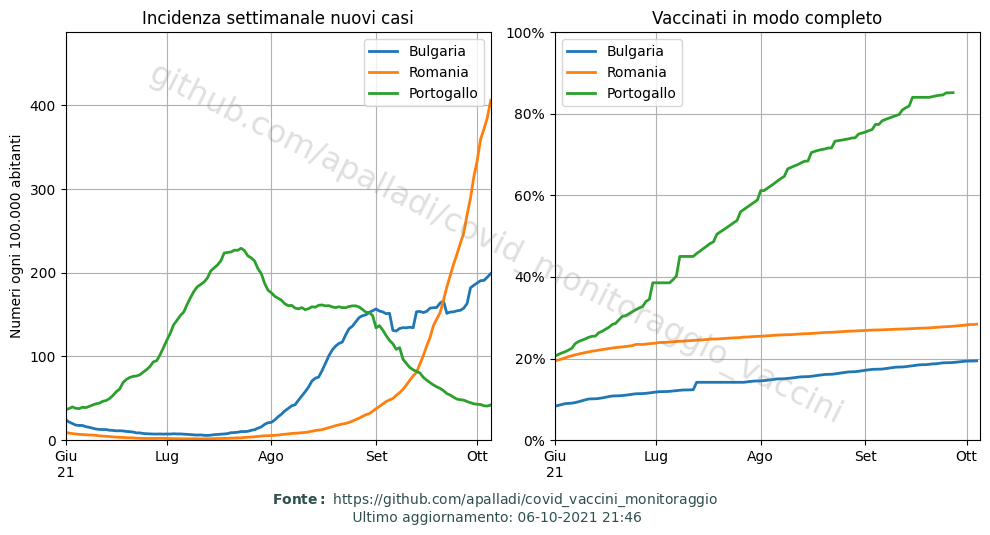

In [7]:
x_date = ['2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01']
x_label = ['Giu\n21', 'Lug', 'Ago', 'Set', 'Ott']
fig, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# unpack all the axes subplots
axes = axes2.ravel()

last_updated = pd.to_datetime(x_date[-1])

new_y_lim = 0

for i in range(len(nomi_nazioni)):
    df_epid = get_epidemic_data(nomi_nazioni[i])
    new_date = df_epid.index[-1]
    # aggiorna limite ascissa...
    if (new_date.month > last_updated.month):
        update_labels(df_epid)
    # ... e data più recente se necessario
    elif (new_date > last_updated):
        last_updated = new_date
    mask = df_epid.index >= '2021-06-01'
    values = 7/(abitanti_nazioni[i]*10)*df_epid['Daily cases (avg 7 days)'][mask]
    if (values.max() > new_y_lim):
        # trova valore massimo
        new_y_lim = values.max()
    # plot
    values.plot(ax=axes[0],
                label=label_nazioni[i], 
                linewidth=2)

# aumenta valore max del 20% per assicurare visibilità grafici
new_y_lim += new_y_lim*0.20

axes[0].set_xlim('2021-06-01', last_updated)
axes[0].set_ylim(0, new_y_lim)
axes[0].set_title('Incidenza settimanale nuovi casi')
axes[0].set_ylabel('Numeri ogni 100.000 abitanti')
axes[0].set_xlabel('')
axes[0].set_xticks(x_date)
axes[0].set_xticklabels(x_label)
axes[0].legend()
axes[0].grid()
axes[0].minorticks_off()

for i in range(len(nomi_nazioni)):
    df_vac = get_vaccine_data(nomi_nazioni[i])
    new_date = df_vac.index[-1]
    # aggiorna limite ascissa...
    if (new_date.month > last_updated.month):
        update_labels(df_vac)
    # ... e data più recente se necessario
    elif (new_date > last_updated):
        last_updated = new_date
    mask = df_vac.index >= '2021-06-01'
    df_vac['% fully vaccinated'][mask].plot(ax=axes[1], 
                   label=label_nazioni[i], linewidth=2)

axes[1].set_xlim('2021-06-01', last_updated)
axes[1].set_ylim(0, 100)
axes[1].set_yticks(np.arange(0, 101, 20))
axes[1].set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes[1].set_title('Vaccinati in modo completo')
axes[1].set_xlabel('')
axes[1].set_xticks(x_date)
axes[1].set_xticklabels(x_label),
axes[1].legend()
axes[1].grid()
axes[1].minorticks_off()

# add watermarks
ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())

plt.tight_layout()
plt.savefig('../risultati/confronto_nazioni_epidemia-vaccino.png', dpi=300, bbox_inches="tight")
plt.show()